In [2]:
import pandas as pd
import os
import time

from math import radians, cos, sin, asin, sqrt


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# found here https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
# Is correct, but quite slow

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [4]:
def fast_distance(lon1, lat1, lon2, lat2):
    R = 6371  # radius of the earth in km
    x = (lon2 - lon1) * cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * sqrt( x*x + y*y ) # distance in km
    
    return d

In [5]:
def check_distance(row):    
    tolerance = 1    # measured in km
    distance = fast_distance(row.Lon, row.Lat, row.RealLon, row.RealLat)
    
    return (True if distance < tolerance else False)

In [6]:

def read_data(filename):

    df = pd.read_csv(filename, low_memory=False, header=None)
    df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
                  "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
                  "AtStop", "HumanTime", "Day", "Hour", "JourneyGroup", "Runtime"]

    
    return df

In [7]:
def filter_distance(df, locations):
    locations = locations.rename(columns={'Lon': 'RealLon', 'Lat': 'RealLat'})
    
    df = pd.merge(df, locations, how='inner', on=['StopID'])
    df["ValidDistance"] = True
    df["ValidDistance"] = df.apply(check_distance, axis=1)
    
    df = df[df.ValidDistance == True]
    
    # Dropping irrelevant columns
    for column in ['RealLat', 'RealLon', 'ValidDistance']:
        df = df.drop(column, 1)
    
    return df

In [8]:
def main(read_directory, write_directory, location_csv):
    
    print("Reading locations")
    locations = pd.read_csv(location_csv)

    for read_file in os.listdir(read_directory):
        if read_file.endswith(".csv"):
            if os.path.isfile(write_directory + "/" + read_file):
                print(read_file, "exists")
            else:
                print("Reading", read_file, "from", read_directory)
                try:
                    df = read_data(read_directory + "/" + read_file)
                    df = filter_distance(df, locations)

                    with open(write_directory + "/" + read_file, 'w+') as f:
                        df.to_csv(f, header=False, index=False)
                except (ValueError, IndexError) as error:
                    print(error, "!")
                    print("Couldn't finish", read_file)
                    
                print("Finished", read_file)
                print()
    print("Finished main!")

In [9]:
read_directory = "bus_data/clean_data5"
write_directory = "bus_data/clean_location_data/"
location_csv = 'bus_data/stop_locations.csv'

# main(read_directory, write_directory, location_csv)

### --Rough work--

In [10]:
line = '15'
# df = read_data('bus_data/clean_data_rough/' + line + '.csv')
# df = pd.read_csv('bus_data/clean_data_rough/' + line + '.csv', low_memory=False)
df = read_data('bus_data/clean_data5/' + line + '.csv')
locations = pd.read_csv('bus_data/stop_locations.csv')

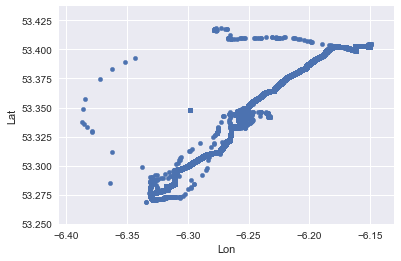

In [11]:
plotdf = df[["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")

In [12]:
df_0001 = df[df.JourneyPatternID == 1]

df_0001.StopID.unique().shape

(72,)

In [13]:
newdf = filter_distance(df, locations)


In [14]:
# df_0001 = newdf[df.JourneyPatternID == 1]

# df_0001.StopID.unique().shape

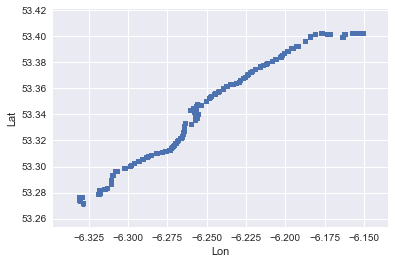

In [15]:
plotdf = newdf[["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")

In [16]:
newdf.head()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,JourneyGroup,Runtime
1,1352182204000000,15,1,2012-11-06,5899,-6.151132,53.402328,33498,6318,0,2012-11-06 06:10:04,1,6,2012-11-065899,0
16,1352192390000000,15,1,2012-11-06,5828,-6.150883,53.402351,33523,6318,1,2012-11-06 08:59:50,1,8,2012-11-065828,0
17,1352192858000000,15,1,2012-11-06,5835,-6.150987,53.402309,33254,6318,1,2012-11-06 09:07:38,1,9,2012-11-065835,0
18,1352193393000000,15,1,2012-11-06,5853,-6.150987,53.402309,33209,6318,1,2012-11-06 09:16:33,1,9,2012-11-065853,0
19,1352194244000000,15,1,2012-11-06,5878,-6.151132,53.402328,33020,6318,0,2012-11-06 09:30:44,1,9,2012-11-065878,0


### Visualising stuff with seaborn

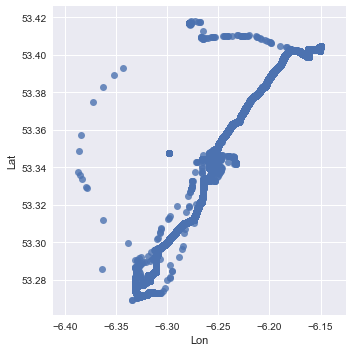

In [23]:
# Scatterplot arguments
sns.lmplot(x='Lon', y='Lat', data=df,
           fit_reg=False, # No regression line
           )

sns.plt.savefig("bus_data/images/direction_locations.png")

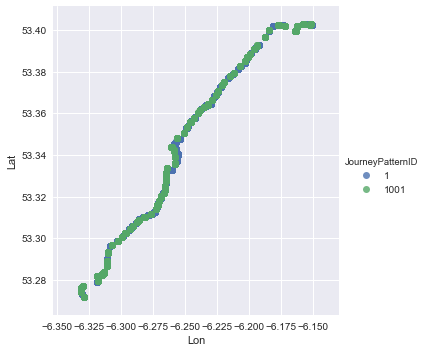

In [18]:
# Scatterplot arguments
cleanplot = sns.lmplot(x='Lon', y='Lat', data=newdf,
           fit_reg=False, # No regression line
            hue='JourneyPatternID')

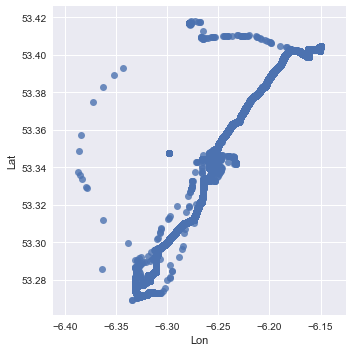

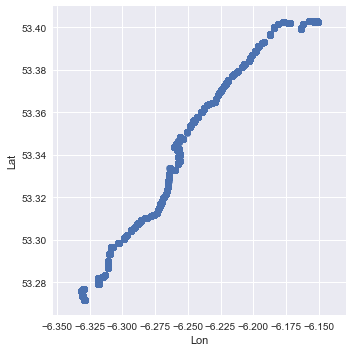

In [19]:
sns.lmplot(x='Lon', y='Lat', data=df,
           fit_reg=False) # No regression line
#             hue='StopID')

sns.lmplot(x='Lon', y='Lat', data=newdf,
           fit_reg=False) # No regression line
#             hue='StopID')

sns.plt.savefig("bus_data/images/clean_locations_15.png")
sns.plt.show()

In [20]:
len(newdf.VehicleID.unique())

196

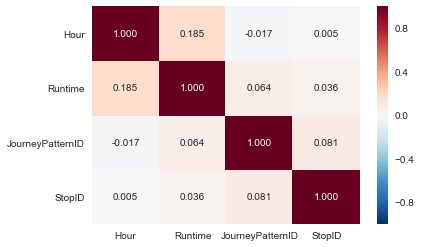

In [21]:
corrdf = newdf[["Hour", "Runtime", "JourneyPatternID", "StopID"]]
sns.heatmap(corrdf.corr(), annot=True, fmt=".3f")


In [22]:
# grouped = df.groupby("Hour").Runtime.mean()

ValueError: x and y must be the same size

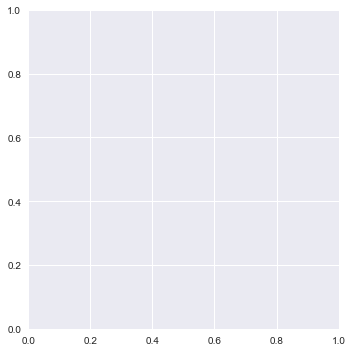

In [23]:
# sns.lmplot(x='Lon', y='Runtime', data=grouped,
#            fit_reg=False) # No regression line
# #             hue='StopID')

In [ ]:
# sns.swarmplot(x="Day", y="Runtime", data=newdf);

In [ ]:
# sns.swarmplot(x="Hour", y="Runtime", data=newdf);

In [ ]:
# changing name of Lat and Lon so that they can be distinguished

locations = locations.rename(columns={'Lon': 'RealLon', 'Lat': 'RealLat'})

In [ ]:
locations.tail()

In [ ]:
df = pd.merge(df, locations, how='inner', on=['StopID'])

In [ ]:
df.shape

In [ ]:
def check_distance(row):    
    tolerance = 1    # measured in km
    distance = fast_distance(row.Lon, row.Lat, row.RealLon, row.RealLat)
    
    return (True if distance < tolerance else False)

df["ValidDistance"] = True
df["ValidDistance"] = df.apply(check_distance, axis=1)

In [ ]:
df.ValidDistance.value_counts()

In [ ]:
trimmed_df = df[df.ValidDistance == True]

In [ ]:
trimmed_df.head()

In [ ]:
plotdf = trimmed_df[["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")